# Test symbolic classification on Digen benchmark

- Generative and reproducible benchmarks for comprehensive evaluation of machine learning classifiers [arxiv](https://arxiv.org/pdf/2107.06475.pdf), [github](https://github.com/EpistasisLab/digen)

In [1]:
import numpy as np, pandas as pd
from digen import Benchmark
from HROCH import NonlinearLogisticRegressor, PseudoClassifier, SymbolicRegressor
from pseudo import GenericPseudoClassifier
from rils_rols.rils_rols import RILSROLSBinaryClassifier, RILSROLSRegressor
from qlattice import QLatticeRegressor
import matplotlib.pyplot as plt
import seaborn as sns

/home/jano/GECCO2023/SR/clf_test/classification_test/test_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jano/GECCO2023/SR/clf_test/classification_test/test_env/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


This version of Feyn and the QLattice is available for academic, personal, and non-commercial use. By using the community version of this software you agree to the terms and conditions which can be found at https://abzu.ai/eula.

## Run benchmark

In [2]:
# TODO: parameters
RANDOM_STATE = 123
TIME_LIMIT = 10 # vary from [1, 10, 100]
NUM_THREADS = 1

# QLatticeRegressor
ql_params = {
    'random_state' : RANDOM_STATE,
    'threads' : NUM_THREADS,
    'kind' : 'classification',
    'max_time' : TIME_LIMIT,
}

# RILSROLSBinaryClassifier
rr_params = {
    'random_state' : RANDOM_STATE,
    'max_seconds' : TIME_LIMIT,
    'max_fit_calls' : 1000000000, # infinity
    #'max_fit_calls' : ITER_LIMIT,
}

# NonlinearLogisticRegressor
hroch_params = {
    'random_state' : RANDOM_STATE,
    'num_threads' : NUM_THREADS,
    'time_limit' : TIME_LIMIT,
    'iter_limit' : 0,
    #'iter_limit' : ITER_LIMIT // 15, # 15 neighbors tested in one iteration
}

pseudo_params = {
    'n' : 8,
    't' : 3.5, 
    'regressor_params' : hroch_params,
}

tested_methods = [
    #('QLattice', QLatticeRegressor(**ql_params)),
    ('RILS-ROLS', RILSROLSBinaryClassifier(**rr_params)),
    ('RILS-ROLS-Pseudo-Generic', GenericPseudoClassifier(t = 3.5, estimator=RILSROLSRegressor(**rr_params))),
    ('HROCH', NonlinearLogisticRegressor(**hroch_params)),
    #('HROCH-Pseudo', PseudoClassifier(**pseudo_params)),
    ('HROCH-Pseudo-Generic', GenericPseudoClassifier(t = 3.5, estimator=SymbolicRegressor(**hroch_params))),
]

benchmark=Benchmark()

res = {}
for name, estimator in tested_methods:
    print(f'Testing {name}')
    res[name] = benchmark.evaluate(estimator, local_cache_dir="../instances/digen/")

Calling with max_fit_calls=1000000000 max_seconds=10 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000000 max_seconds=10 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Testing RILS-ROLS
Calling with max_fit_calls=1000000000 max_seconds=10 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000000 max_seconds=10 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000000 max_seconds=10 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000000 max_seconds=10 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000000 max_seconds=10 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state

## Performance and ranking of the methods across all DIGEN datasets

In [3]:
res_df = [pd.DataFrame.from_dict(res[name]).drop('name', axis=1).transpose() for name, _ in tested_methods]
for idx, df in enumerate(res_df):
    name = tested_methods[idx][0]
    df['classifier'] = name

res_df.append(benchmark.data)
df_results = pd.concat(res_df).reset_index()

[Text(0, 0.30000000000000004, '0.3'),
 Text(0, 0.4, '0.4'),
 Text(0, 0.5, '0.5'),
 Text(0, 0.6000000000000001, '0.6'),
 Text(0, 0.7000000000000001, '0.7'),
 Text(0, 0.8, '0.8'),
 Text(0, 0.9000000000000001, '0.9'),
 Text(0, 1.0, '1.0'),
 Text(0, 1.1, '1.1')]

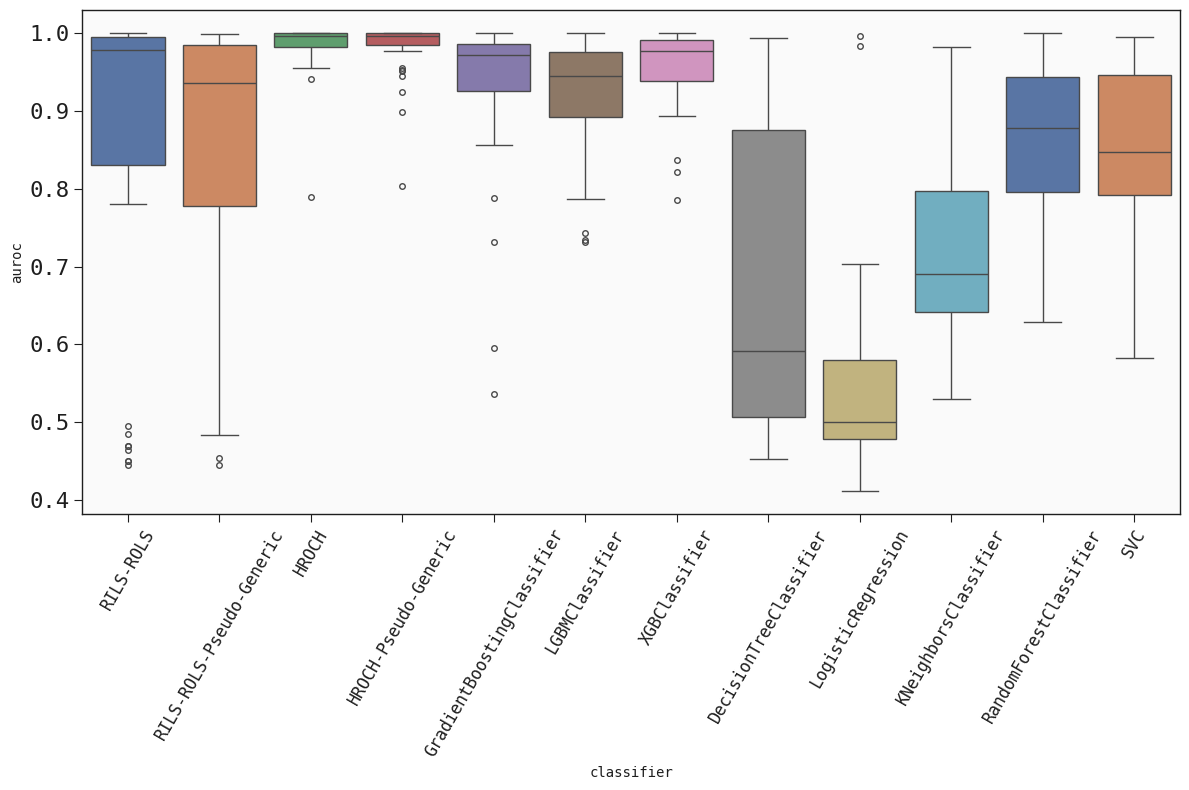

In [4]:
df=df_results[['classifier','dataset','auroc']]
fig,ax = plt.subplots(figsize=(12,8))
ax=sns.boxplot(data=df, x='classifier', y='auroc', ax=ax, palette="deep")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)

## Number of victories visualization

A win-lose chart showing how many times a method in row outperformed a method in column by more than 0.001.

<Axes: >

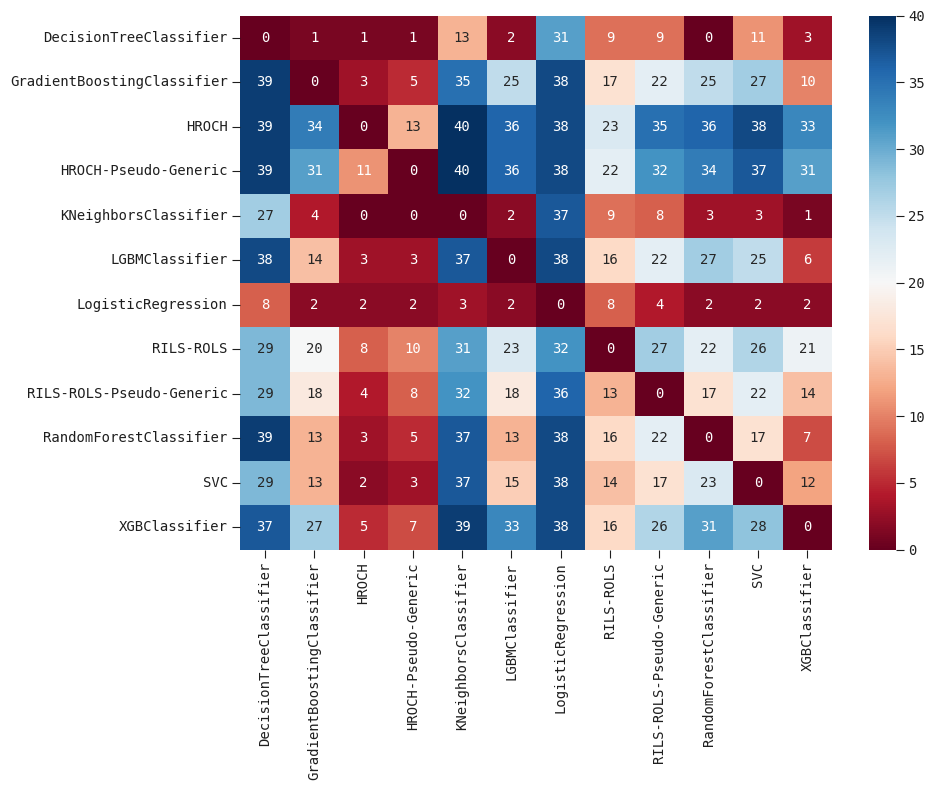

In [5]:
df = df_results.pivot('dataset', columns='classifier', values='auroc')
df = df.astype(float).round(3)
from itertools import product
import seaborn as sns

algorithms = list(df.columns)
wins = pd.DataFrame(index=algorithms, columns=algorithms)

for alg1, alg2 in product(algorithms, algorithms):
    wins.loc[alg1, alg2] = (df[alg1] > df[alg2]).sum()

    
fig = plt.figure(figsize=(10, 8))
sns.heatmap(data=wins.astype(int), annot=True, cmap="RdBu")

## ROC curves comparsion

(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': 'ROC Curves Comparison'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

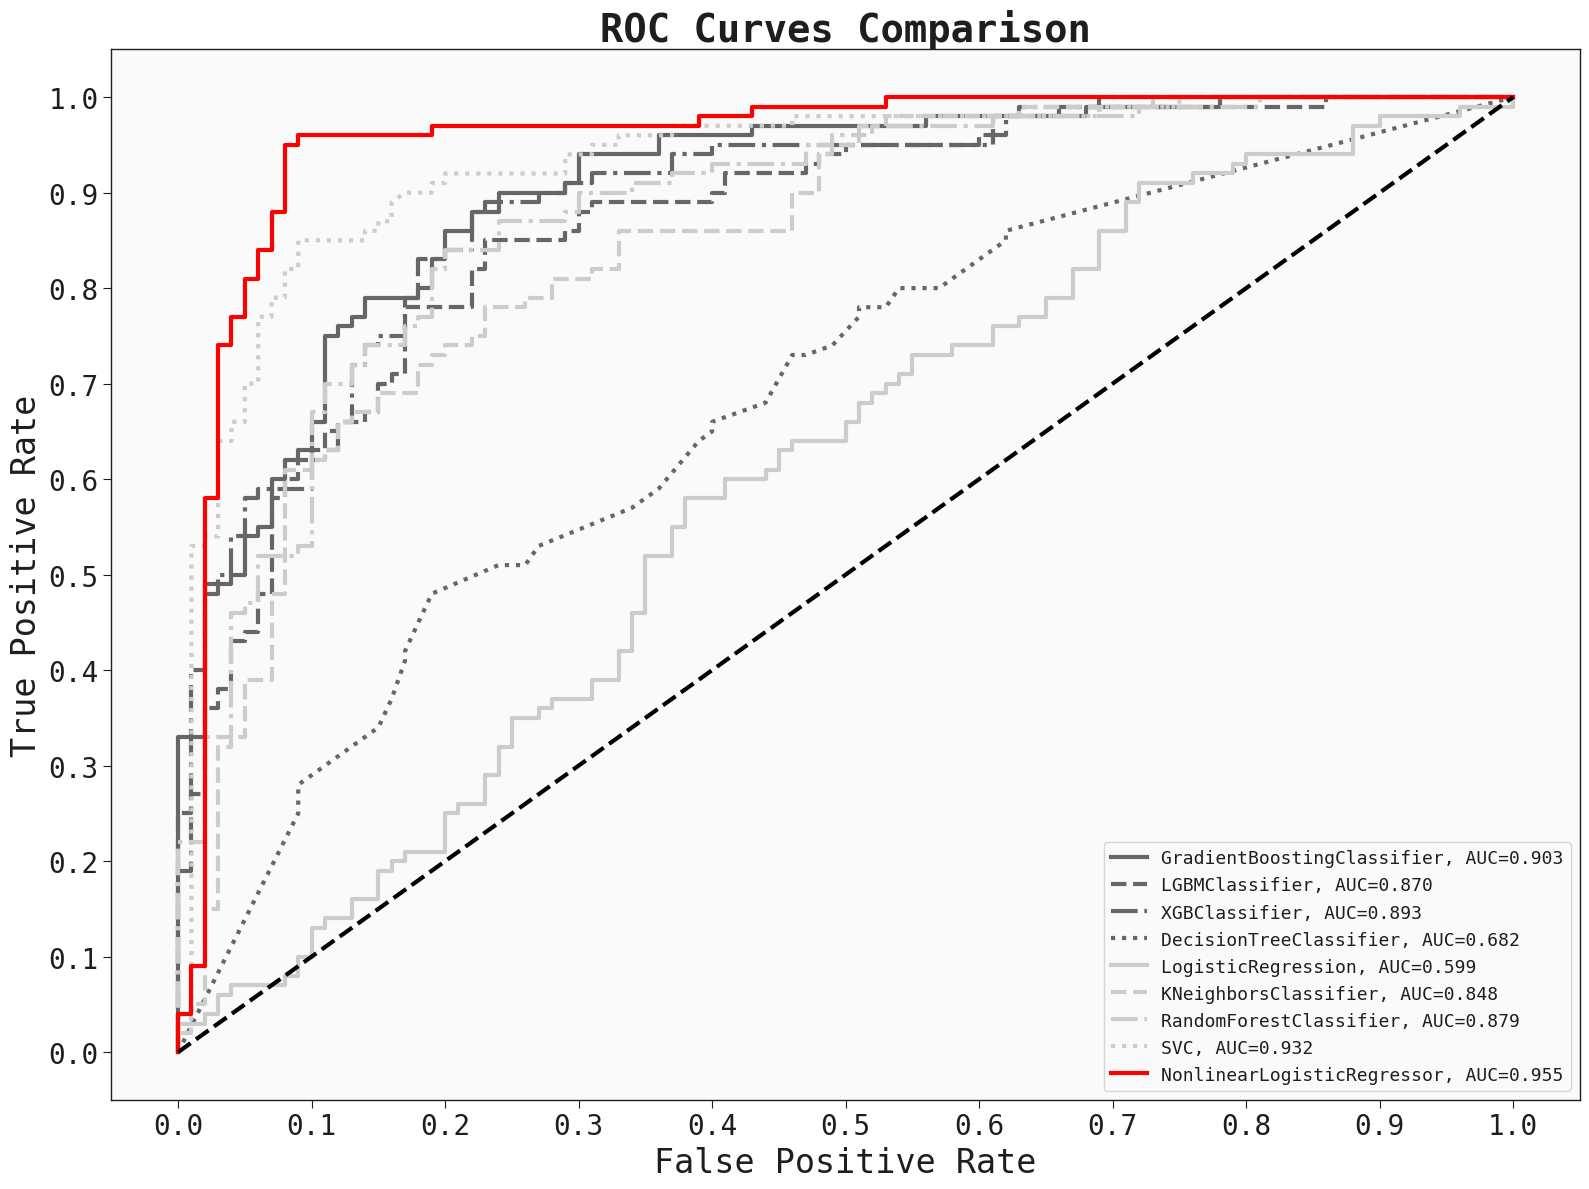

In [6]:
benchmark.plot_roc('digen13_769', new_results=res['HROCH'])

TypeError: cannot pickle 'rils_rols_cpp.rils_rols' object

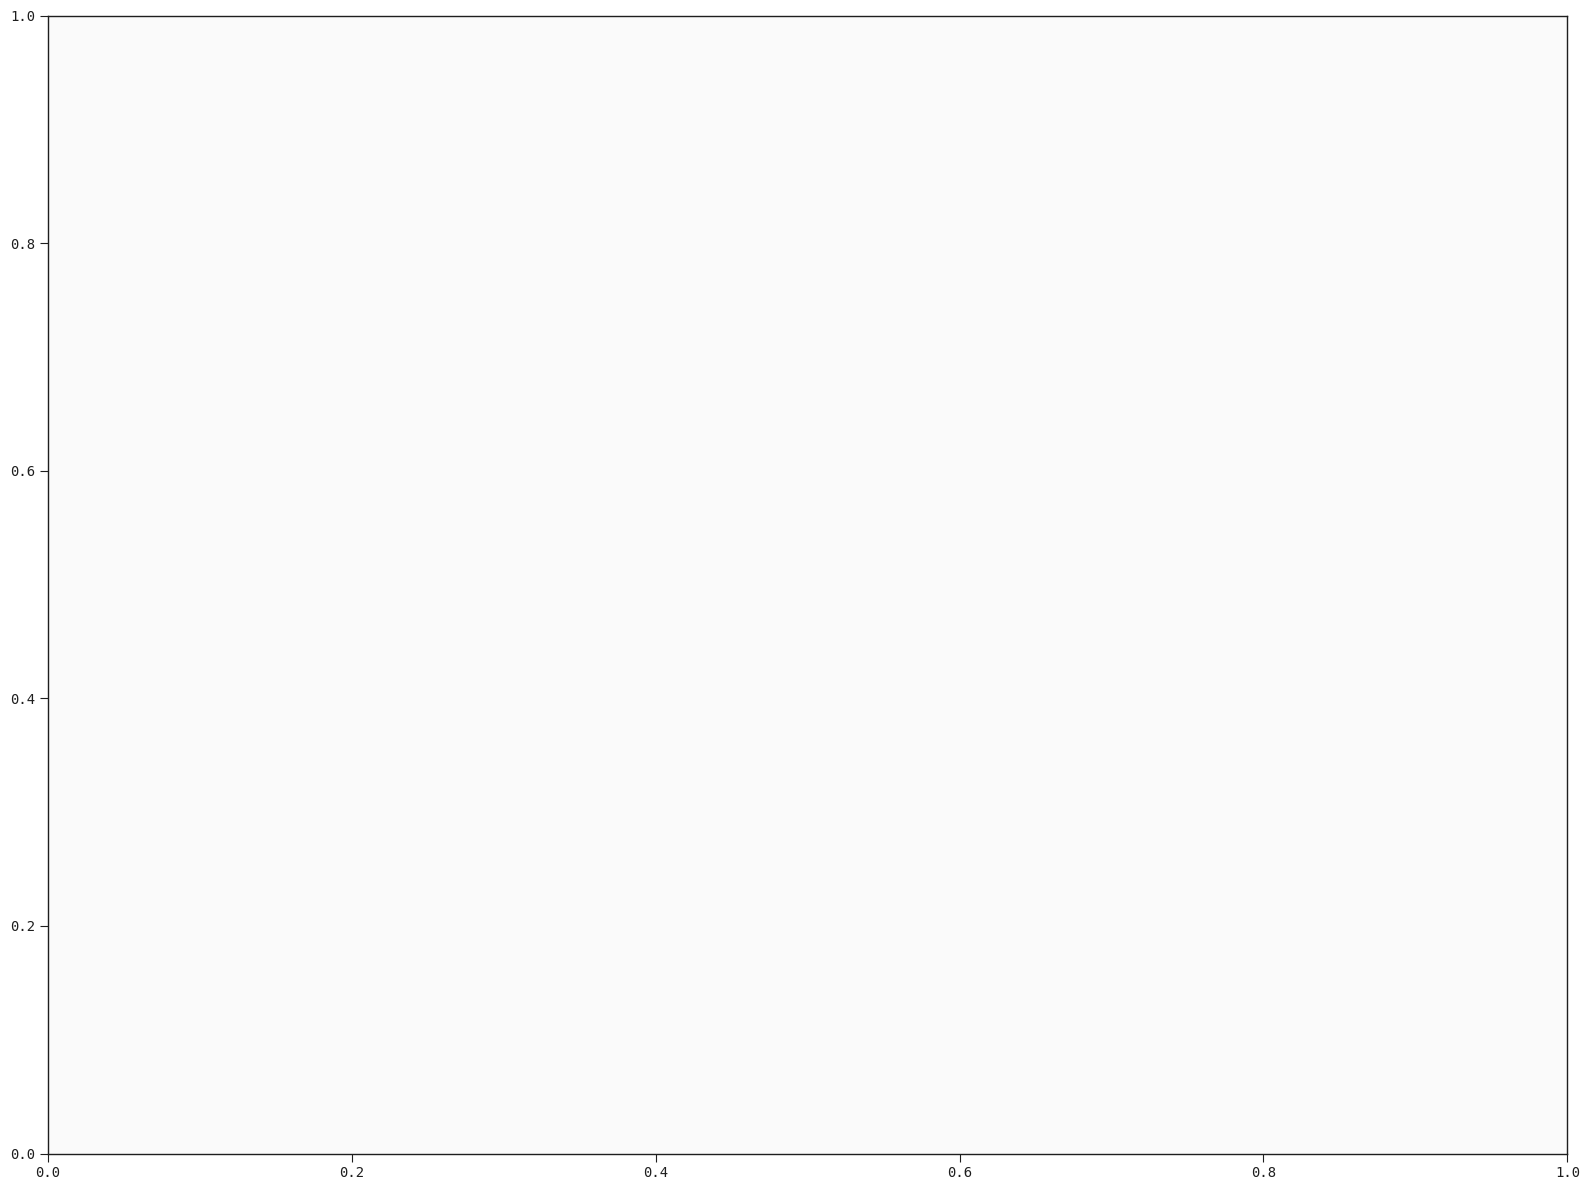

In [7]:
# TODO: TypeError: cannot pickle 'rils_rols_cpp.rils_rols' object
benchmark.plot_roc('digen13_769', new_results=res['RILS-ROLS'])